In [5]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [6]:
train = pd.read_csv('DATASET/train.csv')
test = pd.read_csv('DATASET/test.csv')

In [7]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 12137810 rows and 10 columns
The test data has 3706907 rows and 9 columns


In [8]:
train.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
0,IDsrk7SoW,2017-01-14 09:42:09,4709696.0,887235,17714,20301556,e,Firefox,NaN,0
1,IDmMSxHur,2017-01-18 17:50:53,5189467.0,178235,21407,9434818,b,Mozilla Firefox,Desktop,0
2,IDVLNN0Ut,2017-01-11 12:46:49,98480.0,518539,25085,2050923,a,Edge,NaN,0
3,ID32T6wwQ,2017-01-17 10:18:43,8896401.0,390352,40339,72089744,c,Firefox,Mobile,0
4,IDqUShzMg,2017-01-14 16:02:33,5635120.0,472937,12052,39507200,d,Mozilla Firefox,Desktop,0


In [9]:
# imputing missing values
train['siteid'].fillna(-999, inplace=True)
test['siteid'].fillna(-999, inplace=True)

train['browserid'].fillna("None",inplace=True)
test['browserid'].fillna("None", inplace=True)

train['devid'].fillna("None",inplace=True)
test['devid'].fillna("None",inplace=True)

In [16]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#enc.fit
train = pd.get_dummies(train,columns=['browserid','devid','countrycode'])
test = pd.get_dummies(test,columns=['browserid','devid','countrycode'])

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12137810 entries, 0 to 12137809
Data columns (total 29 columns):
ID                             object
datetime                       object
siteid                         float64
offerid                        int64
category                       int64
merchant                       int64
click                          int64
browserid_Chrome               uint8
browserid_Edge                 uint8
browserid_Firefox              uint8
browserid_Google Chrome        uint8
browserid_IE                   uint8
browserid_Internet Explorer    uint8
browserid_InternetExplorer     uint8
browserid_Mozilla              uint8
browserid_Mozilla Firefox      uint8
browserid_None                 uint8
browserid_Opera                uint8
browserid_Safari               uint8
devid_Desktop                  uint8
devid_Mobile                   uint8
devid_None                     uint8
devid_Tablet                   uint8
countrycode_a                 

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706907 entries, 0 to 3706906
Data columns (total 28 columns):
ID                             object
datetime                       object
siteid                         float64
offerid                        int64
category                       int64
merchant                       int64
browserid_Chrome               uint8
browserid_Edge                 uint8
browserid_Firefox              uint8
browserid_Google Chrome        uint8
browserid_IE                   uint8
browserid_Internet Explorer    uint8
browserid_InternetExplorer     uint8
browserid_Mozilla              uint8
browserid_Mozilla Firefox      uint8
browserid_None                 uint8
browserid_Opera                uint8
browserid_Safari               uint8
devid_Desktop                  uint8
devid_Mobile                   uint8
devid_None                     uint8
devid_Tablet                   uint8
countrycode_a                  uint8
countrycode_b                  u

In [20]:

# create timebased features

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

#train['tweekday'] = train['datetime'].dt.weekday
#test['tweekday'] = test['datetime'].dt.weekday

train['tyear'] = train['datetime'].dt.year
test['tyear'] = test['datetime'].dt.year

train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month

#train['tday'] = train['datetime'].dt.day
#test['tday'] = test['datetime'].dt.day

train['thour'] = train['datetime'].dt.hour
test['thour'] = test['datetime'].dt.hour

train['tminute'] = train['datetime'].dt.minute
test['tminute'] = test['datetime'].dt.minute

In [21]:
# create aggregate features
site_offer_count = train.groupby(['siteid','offerid']).size().reset_index()
site_offer_count.columns = ['siteid','offerid','site_offer_count']

site_offer_count_test = test.groupby(['siteid','offerid']).size().reset_index()
site_offer_count_test.columns = ['siteid','offerid','site_offer_count']

site_cat_count = train.groupby(['siteid','category']).size().reset_index()
site_cat_count.columns = ['siteid','category','site_cat_count']

site_cat_count_test = test.groupby(['siteid','category']).size().reset_index()
site_cat_count_test.columns = ['siteid','category','site_cat_count']

site_mcht_count = train.groupby(['siteid','merchant']).size().reset_index()
site_mcht_count.columns = ['siteid','merchant','site_mcht_count']

site_mcht_count_test = test.groupby(['siteid','merchant']).size().reset_index()
site_mcht_count_test.columns = ['siteid','merchant','site_mcht_count']

In [22]:

# joining all files
agg_df = [site_offer_count,site_cat_count,site_mcht_count]
agg_df_test = [site_offer_count_test,site_cat_count_test,site_mcht_count_test]

for x in agg_df:
    train = train.merge(x)
    
for x in agg_df_test:
    test = test.merge(x)

In [23]:

# Label Encoding
from sklearn.preprocessing import LabelEncoder
for c in list(train.select_dtypes(include=['object']).columns):
    if c != 'ID':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [24]:

# sample 10% data - to avoid memory troubles
# if you have access to large machines, you can use more data for training

#train = train.sample()
print (train.shape)

(12137810, 36)


In [25]:
# select columns to choose
cols_to_use = [x for x in train.columns if x not in list(['ID','datetime','click'])]

In [26]:

# standarise data before training
scaler = StandardScaler().fit(train[cols_to_use])

strain = scaler.transform(train[cols_to_use])
stest = scaler.transform(test[cols_to_use])

In [27]:
# train validation split
X_train, X_valid, Y_train, Y_valid = train_test_split(strain, train.click, test_size = 0.3, random_state=2017)

In [28]:
print (X_train.shape)
print (X_valid.shape)
print (Y_train.shape)
print (Y_valid.shape)

(8496467, 33)
(3641343, 33)
(8496467,)
(3641343,)


In [30]:
# model architechture
def keras_model(train):
    
    input_dim = train.shape[1]
    classes = 2
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (input_dim,)))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(classes, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = ['accuracy','binary_accuracy'])
    return model

callback = EarlyStopping(monitor='val_acc',patience=10)

In [31]:
# one hot target columns
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)

In [32]:
# train model
model = keras_model(X_train)
model.fit(X_train, Y_train, 2000, 100, callbacks=[callback],validation_data=(X_valid, Y_valid),shuffle=True)

Train on 8496467 samples, validate on 3641343 samples
Epoch 1/100
8496467/8496467 [==============================] - 18s - loss: 0.0665 - acc: 0.9773 - val_loss: 0.0641 - val_acc: 0.9778
Epoch 2/100
8496467/8496467 [==============================] - 17s - loss: 0.0640 - acc: 0.9778 - val_loss: 0.0637 - val_acc: 0.9780
Epoch 3/100
8496467/8496467 [==============================] - 17s - loss: 0.0632 - acc: 0.9781 - val_loss: 0.0626 - val_acc: 0.9783
Epoch 4/100
8496467/8496467 [==============================] - 17s - loss: 0.0617 - acc: 0.9787 - val_loss: 0.0611 - val_acc: 0.9790
Epoch 5/100
8496467/8496467 [==============================] - 17s - loss: 0.0605 - acc: 0.9792 - val_loss: 0.0600 - val_acc: 0.9797
Epoch 6/100
8496467/8496467 [==============================] - 17s - loss: 0.0596 - acc: 0.9796 - val_loss: 0.0596 - val_acc: 0.9796
Epoch 7/100
8496467/8496467 [==============================] - 17s - loss: 0.0588 - acc: 0.9799 - val_loss: 0.0585 - val_acc: 0.9801
Epoch 8/100
849

8496467/8496467 [==============================] - 16s - loss: 0.0528 - acc: 0.9816 - val_loss: 0.0538 - val_acc: 0.9814
Epoch 62/100
8496467/8496467 [==============================] - 16s - loss: 0.0527 - acc: 0.9816 - val_loss: 0.0535 - val_acc: 0.9815
Epoch 63/100
8496467/8496467 [==============================] - 16s - loss: 0.0527 - acc: 0.9816 - val_loss: 0.0534 - val_acc: 0.9818
Epoch 64/100
8496467/8496467 [==============================] - 16s - loss: 0.0527 - acc: 0.9816 - val_loss: 0.0534 - val_acc: 0.9815
Epoch 65/100
8496467/8496467 [==============================] - 18s - loss: 0.0526 - acc: 0.9816 - val_loss: 0.0530 - val_acc: 0.9817
Epoch 66/100
8496467/8496467 [==============================] - 18s - loss: 0.0526 - acc: 0.9817 - val_loss: 0.0550 - val_acc: 0.9810
Epoch 67/100
8496467/8496467 [==============================] - 18s - loss: 0.0526 - acc: 0.9816 - val_loss: 0.0527 - val_acc: 0.9817
Epoch 68/100
8496467/8496467 [==============================] - 17s - loss:

In [34]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [35]:
# check validation accuracy
vpreds = model.predict_proba(X_valid)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true = Y_valid[:,1], y_score=vpreds)

3640704/3641343 [============================>.] - ETA: 0s

0.97886618537929382

In [36]:
# predict on test data
test_preds = model.predict_proba(stest)[:,1]

3706624/3706907 [============================>.] - ETA: 0s

In [38]:
# create submission file
submit = pd.DataFrame({'ID':test.ID, 'click':test_preds})
submit.to_csv('Submission/Keras_subNew6.csv', index=False)

In [39]:
from xgboost import XGBClassifier

/home/anirudh/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
test.head()

,ID,datetime,siteid,offerid,category,merchant,browserid_Chrome,browserid_Edge,browserid_Firefox,browserid_Google Chrome,...,countrycode_d,countrycode_e,countrycode_f,tyear,month,thour,tminute,site_offer_count,site_cat_count,site_mcht_count
0,IDFDJVI,2017-01-22 09:55:48,755610.0,808980,17714,26391770,0,0,0,0,...,0,0,0,2017,1,9,55,1,16,14
1,IDfbJpA,2017-01-22 09:55:48,755610.0,794970,17714,26391770,0,0,0,0,...,0,0,1,2017,1,9,55,1,16,14
2,IDF9SUX,2017-01-22 09:55:48,755610.0,862911,17714,26391770,0,1,0,0,...,0,0,0,2017,1,9,55,1,16,14
3,IDwx0Vu,2017-01-22 09:55:48,755610.0,852044,17714,26391770,0,0,0,0,...,0,0,0,2017,1,9,55,1,16,14
4,IDwY76g,2017-01-22 09:55:48,755610.0,259313,17714,26391770,0,0,0,1,...,0,1,0,2017,1,9,55,1,16,14


In [41]:
import gc
del X_valid
del Y_valid
del X_train
del Y_train
#del test
#del model
del submit
#del 
gc.collect()

439

In [42]:
XGB_model = XGBClassifier()

In [43]:
XGB_model.fit(strain, train.click)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [44]:
test_preds2 = XGB_model.predict_proba(stest)[:,1]

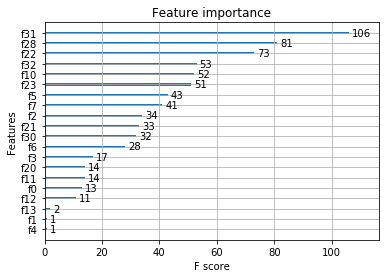

In [45]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(XGB_model)
plt.show()

In [46]:
test_preds2[1]

0.0039577303

In [47]:
test_preds2[2]

0.00078275485

In [48]:
test = pd.read_csv('DATASET/test.csv')

In [49]:
submitXGB = pd.DataFrame({'ID':test.ID, 'click':test_preds2})
submitXGB.to_csv('Submission/XGB2new2.csv', index=False)

In [50]:
test_pred_ensemble = (test_preds2 + test_preds)/2.0
submitE = pd.DataFrame({'ID':test.ID, 'click':test_pred_ensemble})
submitE.to_csv('Submission/ENSEMBLE2new2.csv', index=False)

In [33]:
#X_train.shape

In [34]:
vpreds.shape

(1213781,)

In [35]:
Y_train_pred = model.predict(strain)[:,1]

In [36]:
roc_auc_score(train.click,Y_train_pred)

0.97617703213793139

In [37]:
strain.shape

(12137810, 16)

In [38]:
Y_train_pred.shape

(12137810,)

In [39]:
Data_l1 = pd.DataFrame(data=strain)

In [40]:
Data_l1["Y_pred"]=Y_train_pred

In [41]:
Data_l1.shape

(12137810, 17)

In [42]:
Test_l1 = pd.DataFrame(data=stest)

In [ ]:
Test_l1["Y_pred"] = test_preds

In [ ]:
XGB_model_L2 = XGBClassifier()
XGB_model_L2.fit(Data_l1, train.click)

In [ ]:
test_preds_L2 = XGB_model_L2.predict_proba(Test_l1)[:,1]

In [ ]:
submitXGB_l2 = pd.DataFrame({'ID':test.ID, 'click':test_preds_L2})
#submitXGB_l2.to_csv('Submission/XGB_L2_2.csv', index=False)

In [ ]:
test_preds_L2[1]

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(XGB_model_L2)
plt.show()